# Load data from [Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/)


In [19]:
%matplotlib inline

# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage,misc
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import h5py


## Download data

In [3]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('train.tar.gz', 404141560)
test_filename = maybe_download('test.tar.gz', 276555967)

Found and verified train.tar.gz
Attempting to download: test.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified test.tar.gz


## Extract data

In [7]:
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  nb_files = len([
    file_name for file_name in sorted(os.listdir(root))
    if file_name.endswith(".png")])
  print("found %d image files in %s" % (nb_files,root))
  return root
  
train_folder = maybe_extract(train_filename)
test_folder = maybe_extract(test_filename)

train already present - Skipping extraction of train.tar.gz.
found 33402 image files in train
test already present - Skipping extraction of test.tar.gz.
found 13068 image files in test


## Display some images

displaying 2 sample images from folder train
22041.png


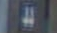

25356.png


displaying 2 sample images from folder test
10206.png


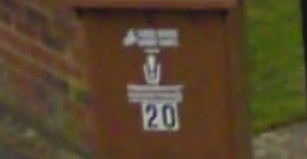

11975.png


In [10]:
def display_sample_images(folder,to_display=5):
    print("displaying %d sample images from folder %s" %(to_display,folder))
    images=[file_name for file_name in sorted(os.listdir(folder)) 
            if file_name.endswith(".png")]
    for image in np.random.choice(images,to_display):
        print(image)
        display(Image(os.path.join(folder, image)))

display_sample_images(train_folder,2)
display_sample_images(test_folder,2)

## Load the data in a more manageable format

In [28]:
image_size = 32  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_folder(folder, min_num_images):
    """Load the data for a folder."""
    dataset= {}
    dataset['height'] = []
    dataset['label'] = []
    dataset['left'] = []
    dataset['top'] = []
    dataset['width'] = []
    dataset['image'] = []
    
    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(f[obj[k][0]][0][0])
        dataset[name].append(vals)
    
    image_files = sorted([file_name for file_name in os.listdir(folder)
                if file_name.endswith(".png")],
                         key=lambda name:int(name[:-4]))
    print ('first_images :')
    print(image_files[:10])
    total_images=len(image_files)
    image_index=-1
    num_images=0
    digitStruct_file = os.path.join(folder, "digitStruct.mat")
    with h5py.File(digitStruct_file,"r") as f:
        for item in f['/digitStruct/bbox']:
            image_index = image_index+1
            image_file = os.path.join(folder, image_files[image_index])
            try:
                image_data = (ndimage.imread(image_file).astype(float) - 
                              pixel_depth / 2) / pixel_depth
                #resize the image to fit our shape
                image_data=misc.imresize(image_data,(image_size, image_size))
                if image_data.shape != (image_size, image_size,3):
                    raise Exception('Unexpected image shape: %s for image %s' % (str(image_data.shape),image_file))
                dataset["image"].append(image_data)
            except IOError as e:
                print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
                continue
            f[item[0]].visititems(print_attrs)
            num_images=num_images+1
            if image_index % 500 == 0:
                percent=image_index*100/total_images
                sys.stdout.write("%d%%" % percent)
                sys.stdout.flush()
            elif image_index % 50 == 0:
                sys.stdout.write(".")
                sys.stdout.flush()
            
    
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                        (num_images, min_num_images))
    
    print('loaded %d images'% len(dataset["image"]))
    return dataset
        
def maybe_pickle(folder, min_num_images_per_class, force=False):
    set_filename = folder + '.pickle'
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
        print('Pickling %s.' % set_filename)
        dataset = load_folder(folder, min_num_images_per_class)
        try:
            with open(set_filename, 'wb') as f:
                pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', set_filename, ':', e)
    return set_filename

train_datasets = maybe_pickle(train_folder, 32000)
test_datasets = maybe_pickle(test_folder, 12000)


Pickling train.pickle.
first_images :
['1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png']
0%.........1%.........2%.........4%.........5%.........7%.........8%.........10%.........11%.........13%.........14%.........16%.........17%.........19%.........20%.........22%.........23%.........25%.........26%.........28%.........29%.........31%.........32%.........34%.........35%.........37%.........38%.........40%.........41%.........43%.........44%.........46%.........47%.........49%.........50%.........52%.........53%.........55%.........56%.........58%.........59%.........61%.........62%.........64%.........65%.........67%.........68%.........70%.........71%.........73%.........74%.........76%.........77%.........79%.........80%.........82%.........83%.........85%.........86%.........88%.........89%.........91%.........92%.........94%.........95%.........97%.........98%........loaded 33402 images
Pickling test.pickle.
first_images :
['1.png', '2.png'

## Display some labels and images to make sure that everything is loaded fine 

showing some labels and images for train.pickle
loaded 33402 images
[8.0, 3.0]
[1.0, 2.0, 10.0]
[2.0, 7.0]
[1.0, 6.0]
[3.0, 5.0]
showing some labels and images for test.pickle
loaded 13068 images
[2.0]
[2.0, 10.0]
[4.0]
[1.0, 10.0, 9.0]
[1.0, 10.0]


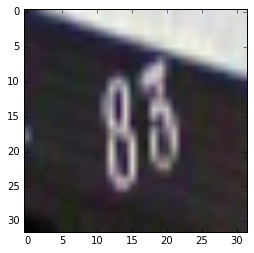

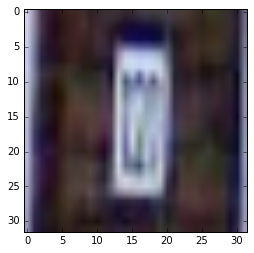

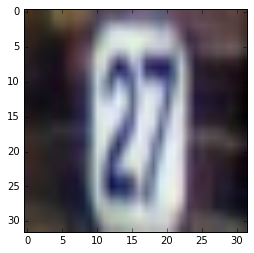

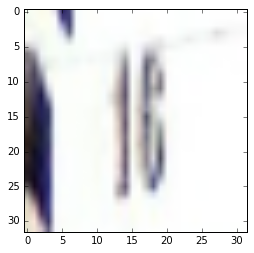

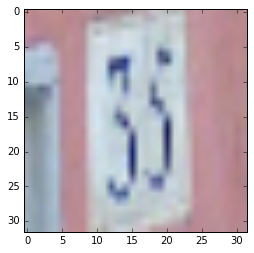

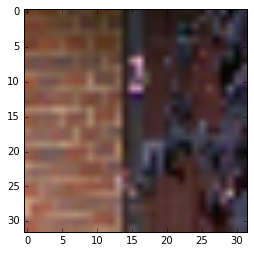

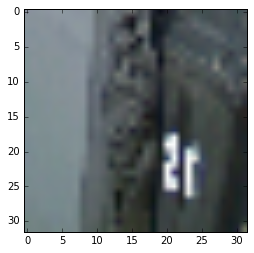

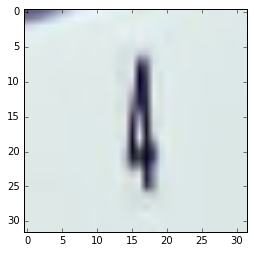

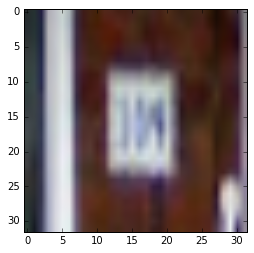

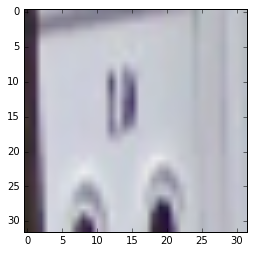

In [33]:
def display_images(file_name,num_images=5):
    print ("showing some labels and images for %s"%file_name)
    with open(file_name, 'r') as f:
        data=pickle.load(f)
        labels=data["label"]
        total_images=len(labels)
        images=data["image"]
        print("loaded %d images"%total_images)
        for i in np.random.choice(total_images,num_images):
            print(labels[i])
            plt.figure()
            plt.imshow(images[i])
            
display_images(train_datasets)
display_images(test_datasets)